In [1]:
# Mateusz Biegański
# mb385162

# Data Mining 2020-2021 course, MIMUW

In [2]:
# Libraries used.

# Python-like fstrings.
library(glue);

# Misc utils.
library(dplyr);

# Plots.
library(ggplot2);

# B-splines for 'ggplot' smooth plots. 
library(splines);

# Reading .csv in efficient way.
library(data.table);

library(glmnet)


In [3]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))
id = function(x) x

In [103]:
TRAIN_DATA_FNAME = "training_data_tabular_format.csv"
TEST_DATA_FNAME = "test_data_tabular_format.csv"
DATA_LEN=3000


gen_model_matrix = function(fname, data_len=10000) {
    df <- fread(fname)
    print(dim(df))
    tmp <- which(colSums(is.na(df)) < dim(df)[[1]]/5) # remove columns with >20% of NAs
    df <- df[, ..tmp]
    print(dim(df))
    tmp <- (names(df) %in% c("players.0.ai", "players.1.ai", "id", "players.1.player_id", "players.0.player_id")) # those values are irrelevant
    df <- df[, -..tmp]
    print(dim(df))
    df <- df[sample(nrow(df), data_len), ]
    y <- df %>% select("winner")
    y <- y %>% as.matrix %>% t
    t <- df[,"t"]
    df <- df %>% select(-"t")
    print(dim(df))
    
    invisible(gc())
    mm <- model.matrix(~.-winner, df)
    mm <- cbind(mm, t)
    mm <- as.matrix(mm)
    print(dim(mm))
    invisible(gc())
    list(mm, y)
}

Xy <- gen_model_matrix(TRAIN_DATA_FNAME, DATA_LEN)
mm <- Xy[[1]]
y  <- Xy[[2]]
head(mm, n=3)
head(y, n=3)

[1] 38658   198
[1] 38658   172
[1] 38658   167
[1] 3000  166
[1] 3000 1579


(Intercept),version0.13.3,version0.9.2,version1.0.0,map_nameMap02,map_nameMap03,map_nameMap04,map_nameMap05,map_nameMap06,map_nameMap07,⋯,teams.1.3.gadgets_stats.4.idshd05,teams.1.3.gadgets_stats.4.idshd06,teams.1.3.gadgets_stats.4.idsprnt01,teams.1.3.gadgets_stats.4.idstm01,teams.1.3.gadgets_stats.4.idstm02,teams.1.3.gadgets_stats.4.idstm03,teams.1.3.gadgets_stats.4.idstm04,teams.1.3.gadgets_stats.4.idstm05,teams.1.3.gadgets_stats.4.cnt,t
1,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,215.3804
1,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,53.9094
1,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,2,110.6863


winner,0,1,0,0,0,1,0,0,1,1,⋯,1,0,1,0,0,0,0,1,1,1



Call:  cv.glmnet(x = mm, y = y, type.measure = "class", parallel = TRUE,      family = "binomial", alpha = 1) 

Measure: Misclassification Error 

     Lambda Index Measure       SE Nonzero
min 0.02247    18  0.2550 0.008333      28
1se 0.02970    15  0.2633 0.008763      18


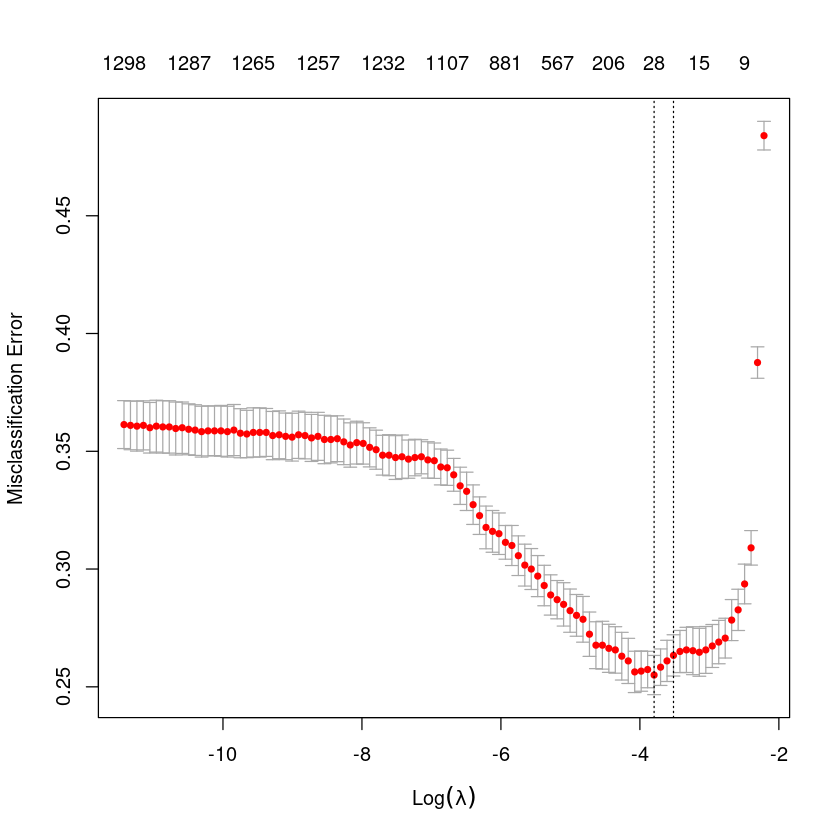

In [86]:
library(doParallel)
registerDoParallel(4)

cvfit <- cv.glmnet(mm, y, family = "binomial", type.measure = "class", alpha=1, parallel=TRUE)

print(cvfit)
plot(cvfit)

In [104]:
gen_test_model_matrix = function(fname, train_mm, data_len=10000) {
    df <- fread(fname)
    dim(df)
    
    tmp <- which(colSums(is.na(df)) < 1) # remove columns with >20% of NAs   dim(df)[[1]]/5
    df <- df[, ..tmp]
    dim(df)
    
    tmp <- (names(df) %in% c("players.0.ai", "players.1.ai", "id", "players.1.player_id", "players.0.player_id")) # those values are irrelevant
    df <- df[, -..tmp]
    dim(df)
#     df <- df[sample(nrow(df), data_len), ]
    t <- df[,"t"]
    df <- df %>% select(-"t")
    dim(df)
    
    mm <- model.matrix(~., df)
    mm <- cbind(mm, t)
    mm <- as.matrix(mm)
    invisible(gc())
    mm
}


test_mm <- gen_test_model_matrix(TEST_DATA_FNAME, mm, 20000)


head(test_mm)

# cvfit %>% predict(as.matrix(test_mm), type="response")

(Intercept),version0.12.0,version0.12.1,version0.13.3,version0.9.2,version1.0.0,map_nameMap02,map_nameMap03,map_nameMap04,map_nameMap05,⋯,teams.1.3.gadgets_stats.4.idshd05,teams.1.3.gadgets_stats.4.idshd06,teams.1.3.gadgets_stats.4.idsprnt01,teams.1.3.gadgets_stats.4.idstm01,teams.1.3.gadgets_stats.4.idstm02,teams.1.3.gadgets_stats.4.idstm03,teams.1.3.gadgets_stats.4.idstm04,teams.1.3.gadgets_stats.4.idstm05,teams.1.3.gadgets_stats.4.cnt,t
1,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,80.00335
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,243.32095
1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,84.58365
1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,76.41979
1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,152.01454
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,122.96463


In [126]:
# cvfit %>% predict(as.matrix(test_mm), type="response")
# dim(test_mm)
# dim(mm)

test_mm <- test_mm[,which(colnames(test_mm) %in% colnames(mm))]
dim(test_mm)
dim(mm)
# test_mm[,"winner"]
# mm[,"winner"]
# cvfit %>% predict(as.matrix(test_mm), type="response")

# mm[,-which(colnames(mm) %in% colnames(test_mm))]
setdiff(1:1579, which(colnames(mm) %in% colnames(test_mm)))
colnames(mm)[1560]

[1] 20000  1578

[1] 3000 1579

[1] 1560

[1] "teams.1.3.gadgets_stats.4.idmin01"

In [77]:
# head(mm)
colnames(mm)

[1] "(Intercept)"                          
   [2] "version0.12.0"                        
   [3] "version0.12.1"                        
   [4] "version0.13.3"                        
   [5] "version0.9.2"                         
   [6] "map_nameMap02"                        
   [7] "map_nameMap03"                        
   [8] "map_nameMap04"                        
   [9] "map_nameMap05"                        
  [10] "map_nameMap06"                        
  [11] "map_nameMap07"                        
  [12] "map_nameMap08"                        
  [13] "map_nameMap09"                        
  [14] "map_nameMap10"                        
  [15] "map_nameMap11"                        
  [16] "map_nameMap12"                        
  [17] "map_nameMap13"                        
  [18] "map_nameMap14"                        
  [19] "map_nameMap15"                        
  [20] "map_nameMap16"                        
  [21] "map_nameMap17"                        
  [22] "map_nameMap18"                        
  [23] "map_nameMap19"                        
  [24] "map_nameMap20"                        
  [25] "map_nameMap21"                        
  [26] "map_nameMap22"                        
  [27] "map_nameMap23"                        
  [28] "map_nameMap24"                        
  [29] "modeDomination"                       
  [30] "turn_no"                              
  [31] "to_move"                              
  [32] "teams.0.0.unit_typeunt02"             
  [33] "teams.0.0.unit_typeunt03"             
  [34] "teams.0.0.unit_typeunt04"             
  [35] "teams.0.0.dead"                       
  [36] "teams.0.0.current_ap"                 
  [37] "teams.0.0.current_hp"                 
  [38] "teams.0.0.armor.hp"                   
  [39] "teams.0.0.armor.idarm01"              
  [40] "teams.0.0.armor.idarm02"              
  [41] "teams.0.0.armor.idarm03"              
  [42] "teams.0.0.armor.idarm04"              
  [43] "teams.0.0.armor.idarm05"              
  [44] "teams.0.0.armor.idarm06"              
  [45] "teams.0.0.weapons_stats.0.idwpn02"    
  [46] "teams.0.0.weapons_stats.0.idwpn03"    
  [47] "teams.0.0.weapons_stats.0.idwpn05"    
  [48] "teams.0.0.weapons_stats.0.idwpn06"    
  [49] "teams.0.0.weapons_stats.0.idwpn08"    
  [50] "teams.0.0.weapons_stats.0.idwpn09"    
  [51] "teams.0.0.weapons_stats.0.idwpn10"    
  [52] "teams.0.0.weapons_stats.0.idwpn11"    
  [53] "teams.0.0.weapons_stats.0.idwpn12"    
  [54] "teams.0.0.weapons_stats.0.idwpn13"    
  [55] "teams.0.0.weapons_stats.0.idwpn14"    
  [56] "teams.0.0.weapons_stats.0.idwpn15"    
  [57] "teams.0.0.weapons_stats.0.idwpn16"    
  [58] "teams.0.0.weapons_stats.0.idwpn17"    
  [59] "teams.0.0.weapons_stats.0.idwpn18"    
  [60] "teams.0.0.weapons_stats.0.idwpn19"    
  [61] "teams.0.0.weapons_stats.0.idwpn20"    
  [62] "teams.0.0.weapons_stats.0.idwpn21"    
  [63] "teams.0.0.weapons_stats.0.idwpn22"    
  [64] "teams.0.0.weapons_stats.0.idwpn23"    
  [65] "teams.0.0.weapons_stats.0.idwpn24"    
  [66] "teams.0.0.weapons_stats.0.idwpn25"    
  [67] "teams.0.0.weapons_stats.0.idwpn26"    
  [68] "teams.0.0.weapons_stats.0.idwpn27"    
  [69] "teams.0.0.weapons_stats.0.idwpn28"    
  [70] "teams.0.0.weapons_stats.0.idwpn29"    
  [71] "teams.0.0.weapons_stats.0.idwpn30"    
  [72] "teams.0.0.weapons_stats.0.idwpn31"    
  [73] "teams.0.0.weapons_stats.0.idwpn32"    
  [74] "teams.0.0.weapons_stats.0.idwpn33"    
  [75] "teams.0.0.weapons_stats.0.idwpn34"    
  [76] "teams.0.0.weapons_stats.0.cnt"        
  [77] "teams.0.0.weapons_stats.1.idwpn02"    
  [78] "teams.0.0.weapons_stats.1.idwpn03"    
  [79] "teams.0.0.weapons_stats.1.idwpn05"    
  [80] "teams.0.0.weapons_stats.1.idwpn06"    
  [81] "teams.0.0.weapons_stats.1.idwpn08"    
  [82] "teams.0.0.weapons_stats.1.idwpn09"    
  [83] "teams.0.0.weapons_stats.1.idwpn10"    
  [84] "teams.0.0.weapons_stats.1.idwpn11"    
  [85] "teams.0.0.weapons_stats.1.idwpn12"    
  [86] "

In [35]:
model <- fit
p <- fit %>% predict(XD)
probabilities <- model %>% predict(newx = XD)
predicted.classes <- ifelse(probabilities > 0.5, "pos", "neg")
# Model accuracy
# observed.classes <- XD$diabetes
# mean(predicted.classes == observed.classes)
# head(p)
predicted.classes

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,⋯,s90,s91,s92,s93,s94,s95,s96,s97,s98,s99
1,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
2,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
3,neg,neg,neg,neg,neg,neg,neg,neg,neg,pos,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
4,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
5,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
6,neg,neg,neg,neg,neg,neg,neg,neg,neg,pos,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
7,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg
8,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
9,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,pos,pos,pos,pos,pos,pos,pos,pos,pos,pos
10,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg,⋯,neg,neg,neg,neg,neg,neg,neg,neg,neg,neg


In [25]:
LASSO_ALPHA = 1

glmnet(X, y, family = "binomial", alpha = LASSO_ALPHA, lambda = NULL)

Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”


ERROR: Error in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, : NA/NaN/Inf in foreign function call (arg 5)
